In [1]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"

In [2]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/141 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--25-1014183.db,25,baseline,,0.11312,3.332234,0.00000,1.000000
1,run-policy-baseline--25-1014190.db,25,baseline,,0.11296,4.016446,0.00000,1.000000
2,run-policy-baseline--25-1014196.db,25,baseline,,0.18548,3.455797,0.00000,1.000000
3,run-policy-baseline--25-1014202.db,25,baseline,,0.15836,2.968843,0.00000,1.000000
4,run-policy-baseline--25-1014208.db,25,baseline,,0.16756,3.890374,0.00000,1.000000
...,...,...,...,...,...,...,...,...
136,run-policy-ib--25-1014219.db,25,ib,,0.20044,0.507706,0.97449,0.173469
137,run-policy-ib--25-1014225.db,25,ib,,0.35324,0.467037,0.97449,0.168367
138,run-policy-ib--25-1014231.db,25,ib,,0.49188,0.485386,0.97449,0.147959
139,run-policy-ib--25-1014237.db,25,ib,,0.25312,0.408355,0.97449,0.112245


In [3]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        25
policy   parg    
baseline       10
ea       25    10
         50    10
         75    10
eb       25    11
         50    10
         75    10
ec       100   10
         50    10
         75    10
ia       1+1   10
         1+2   10
         2+1   10
ib             10

In [4]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="mean")

n_train              25
policy   parg          
baseline       3.430606
ea       25    2.647322
         50    1.769975
         75    0.942722
eb       25    0.242845
         50    0.708117
         75    1.759758
ec       100   8.017628
         50    4.357186
         75    5.424459
ia       1+1   1.809749
         1+2   2.335885
         2+1   1.254534
ib             0.535648

In [5]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cost", aggfunc="mean")

n_train              25
policy   parg          
baseline       0.160764
ea       25    0.180960
         50    0.219608
         75    0.210628
eb       25    0.269578
         50    0.277628
         75    0.216660
ec       100   0.180440
         50    0.191140
         75    0.161140
ia       1+1   0.206972
         1+2   0.182520
         2+1   0.269912
ib             0.293584

In [6]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "2+1"),
    ("ia", "1+1"),
    ("ia", "1+2"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / df_agg.at[("baseline", ""), "cost"]
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / df_agg.at[("baseline", ""), "cpu_time"]
    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
# df100 = df.loc[df["n_train"] == "100"].copy()

df25_agg = agg(df25)
# df100_agg = agg(df100)

In [7]:
df25_agg #.to_excel("tmp.xlsx")

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1608                  1.0000    3.4306   
ea       25    0.1810                  1.1256    2.6473   
         50    0.2196                  1.3660    1.7700   
         75    0.2106                  1.3102    0.9427   
eb       75    0.2167                  1.3477    1.7598   
         50    0.2776                  1.7269    0.7081   
         25    0.2696                  1.6769    0.2428   
ec       100   0.1804                  1.1224    8.0176   
         75    0.1611                  1.0023    5.4245   
         50    0.1911                  1.1889    4.3572   
ia       2+1   0.2699                  1.6789    1.2545   
         1+1   0.2070                  1.2874    1.8097   
         1+2   0.1825                  1.1353    2.3359   
ib             0.2936                  1.8262    0.5356   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct  
policy   parg                                                       
baseline                           1.0000         0.0000    1.0000  
ea       25                        0.7717         0.2442    0.7578  
         50                        0.5159         0.4896    0.5155  
         75                        0.2748         0.7311    0.2763  
eb       75                        0.5130         0.9745    0.7684  
         50                        0.2064         0.9745    0.5362  
         25                        0.0708         0.9745    0.3050  
ec       100                       2.3371         0.9745    1.0000  
         75                        1.5812         0.9745    1.0000  
         50                        1.2701         0.9745    1.0000  
ia       2+1                       0.3657         0.6531    0.3520  
         1+1                       0.5275         0.4898    0.5128  
         1+2                       0.6809         0.3265    0.6760  
ib                                 0.1561         0.9745    0.1587

In [8]:
# df100_agg

In [21]:
df.loc[(df["policy"] == "eb") & (df["parg"] == "25") & (df["n_train"] == "25")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
43,run-policy-eb-25-25-1014757.db,25,eb,25,0.13932,0.140340,0.97449,0.305714
40,run-policy-eb-25-25-1014733.db,25,eb,25,0.14744,0.329992,0.97449,0.302041
46,run-policy-eb-25-25-1014781.db,25,eb,25,0.15928,0.154023,0.97449,0.305714
41,run-policy-eb-25-25-1014741.db,25,eb,25,0.20432,0.259146,0.97449,0.305714
50,run-policy-eb-25-25-1014962.db,25,eb,25,0.21012,0.349948,0.97449,0.305714
47,run-policy-eb-25-25-1014789.db,25,eb,25,0.23952,0.150022,0.97449,0.305714
49,run-policy-eb-25-25-1014805.db,25,eb,25,0.25064,0.262001,0.97449,0.305714
44,run-policy-eb-25-25-1014765.db,25,eb,25,0.25144,0.343143,0.97449,0.305714
48,run-policy-eb-25-25-1014797.db,25,eb,25,0.25776,0.229158,0.97449,0.302041
42,run-policy-eb-25-25-1014749.db,25,eb,25,0.26892,0.249364,0.97449,0.305714


In [14]:
db = DB(PHASE2_DIR / "run-policy-eb-25-25-1014773.db")
results = db.get_results()

In [17]:
results.loc[lambda x: x["surrogate"].eq(1)]

,id,prefix,solver_id,instance_id,cost,time,cut_off_cost,cut_off_time,cached,surrogate,error
125,config;solver=1;attempt=1;aac_iter=6;surrogate...,config;solver=1;attempt=1;aac_iter=6;surrogate,1329159400041560165,295394930200002165,3.222061,0.0,78.3,7.83,0,1,0
126,config;solver=1;attempt=1;aac_iter=6;surrogate...,config;solver=1;attempt=1;aac_iter=6;surrogate,1329159400041560165,1684327510118630316,2.707398,0.0,6.8,0.68,0,1,0
127,config;solver=1;attempt=1;aac_iter=6;surrogate...,config;solver=1;attempt=1;aac_iter=6;surrogate,1329159400041560165,2279135601872977991,3.229718,0.0,51.8,5.18,0,1,0
128,config;solver=1;attempt=1;aac_iter=6;surrogate...,config;solver=1;attempt=1;aac_iter=6;surrogate,1329159400041560165,1836813281901726231,2.997093,0.0,5.2,0.52,0,1,0
129,config;solver=1;attempt=1;aac_iter=6;surrogate...,config;solver=1;attempt=1;aac_iter=6;surrogate,1329159400041560165,974667721789580017,1.490808,0.0,2.0,0.20,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9221,config;solver=2;attempt=4;aac_iter=25;surrogat...,config;solver=2;attempt=4;aac_iter=25;surrogate,1572540349017271031,1992493799529741414,23.982630,0.0,47.3,4.73,0,1,0
9223,config;solver=2;attempt=4;aac_iter=25;surrogat...,config;solver=2;attempt=4;aac_iter=25;surrogate,1572540349017271031,1533732088008481340,0.705583,0.0,3.5,0.35,0,1,0
9225,config;solver=2;attempt=4;aac_iter=25;surrogat...,config;solver=2;attempt=4;aac_iter=25;surrogate,1572540349017271031,521285588651079597,1.689452,0.0,9.0,0.90,0,1,0
9227,config;solver=2;attempt=4;aac_iter=25;surrogat...,config;solver=2;attempt=4;aac_iter=25;surrogate,1572540349017271031,616928534534399267,3.896236,0.0,14.7,1.47,0,1,0


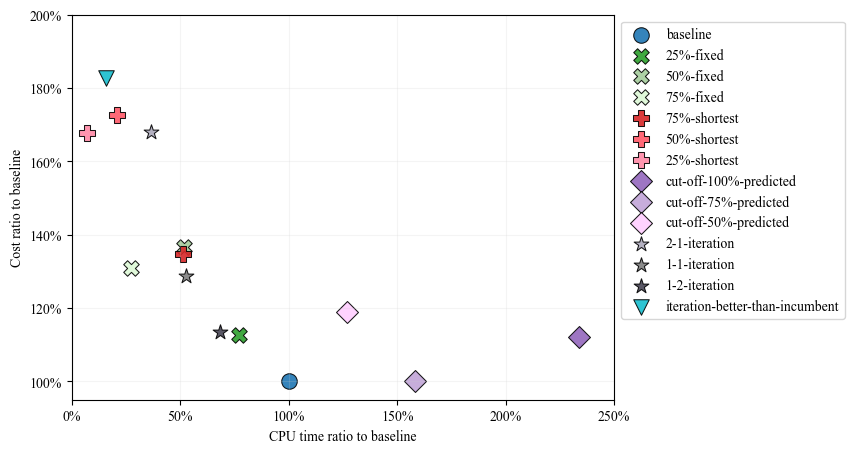

In [122]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0
fig, ax = plt.subplots(figsize=(7, 5))

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#2ca02c",
    ("ea", "50"): "#a4cb9b",
    ("ea", "75"): "#ddf8d6",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#474554", 
    ("ia", "1+1"): "#7f7f7f",
    ("ia", "2+1"): "#aca9bb",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-fixed",
    ("ea", "50"): "50%-fixed",
    ("ea", "75"): "75%-fixed",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "v",
}

for (policy, parg), row in df25_agg.iterrows():
    plt.scatter(
        row["cpu_time_ratio_to_baseline"],
        row["cost_ratio_to_baseline"],
        s=125,
        alpha=0.9,
        color=COLORS[(policy, parg)],
        marker=MARKERS[policy],
        linewidths=0.75,
        edgecolor="black",
        label=LABELS[(policy, parg)],
    )

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("CPU time ratio to baseline")
plt.ylabel("Cost ratio to baseline")
plt.xlim(0, 2.5)
plt.ylim(0.95, 2)
plt.show()

In [ ]:
baseline_cost = df25_agg

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1608                  1.0000    3.4306   
ea       25    0.1810                  1.1256    2.6473   
         50    0.2196                  1.3660    1.7700   
         75    0.2106                  1.3102    0.9427   
eb       75    0.2167                  1.3477    1.7598   
         50    0.2776                  1.7269    0.7081   
         25    0.2696                  1.6769    0.2428   
ec       100   0.1804                  1.1224    8.0176   
         75    0.1611                  1.0023    5.4245   
         50    0.1911                  1.1889    4.3572   
ia       2+1   0.2699                  1.6789    1.2545   
         1+1   0.2070                  1.2874    1.8097   
         1+2   0.1825                  1.1353    2.3359   
ib             0.2936                  1.8262    0.5356   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct  
policy   parg                                                       
baseline                           1.0000         0.0000    1.0000  
ea       25                        0.7717         0.2442    0.7578  
         50                        0.5159         0.4896    0.5155  
         75                        0.2748         0.7311    0.2763  
eb       75                        0.5130         0.9745    0.7684  
         50                        0.2064         0.9745    0.5362  
         25                        0.0708         0.9745    0.3050  
ec       100                       2.3371         0.9745    1.0000  
         75                        1.5812         0.9745    1.0000  
         50                        1.2701         0.9745    1.0000  
ia       2+1                       0.3657         0.6531    0.3520  
         1+1                       0.5275         0.4898    0.5128  
         1+2                       0.6809         0.3265    0.6760  
ib                                 0.1561         0.9745    0.1587